<a href="https://colab.research.google.com/github/MohamedElgabryy/Decision-Tree-Bayesian-Classifiers/blob/main/Decision_Tree_Bayesian_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the percentage of data to be read (0-100): 70
----------------------------------------------------------
Bayesian Classifier Accuracy: 0.8578199052132701
Decision Tree Classifier Accuracy: 0.8341232227488151
----------------------------------------------------------


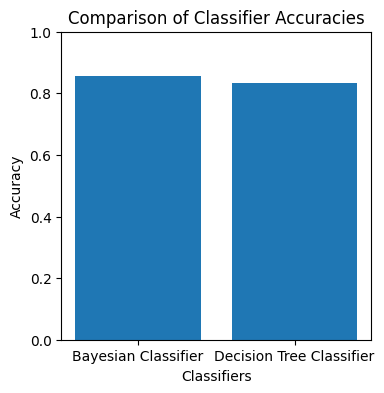

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Read the dataset from the CSV file
file_path = 'bank_dataset.csv'
percentage = float(input("Enter the percentage of data to be read (0-100): "))
print("----------------------------------------------------------")
data = pd.read_csv(file_path, nrows=int(percentage / 100 * sum(1 for _ in open(file_path))))

# Select relevant features and the target variable
selected_features = ['age', 'job', 'marital', 'education', 'housing']
target_variable = 'y'
data = data[selected_features + [target_variable]]


# Decision Tree Classifier
class DecisionTreeClassifier:
    def __init__(self):
        self.tree = None

    def train(self, X, y):
        self.tree = self.build_tree(X, y)

    def build_tree(self, X, y):
        # Base case
        if len(np.unique(y)) == 1 or len(X.columns) == 0:
            return np.unique(y)[0]

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None or best_threshold is None:
            return np.argmax(np.bincount(y))

        # Split the dataset
        left_X = X[X[best_feature] <= best_threshold]
        left_y = y[X[best_feature] <= best_threshold]
        right_X = X[X[best_feature] > best_threshold]
        right_y = y[X[best_feature] > best_threshold]

        # Check if either the left or right subset is empty, and if so, return the majority class of the parent node
        if left_X.empty or right_X.empty:
            return np.argmax(np.bincount(y))

        # Recursive call to build the left and right subtrees
        left_subtree = self.build_tree(left_X, left_y)
        right_subtree = self.build_tree(right_X, right_y)

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_subtree, 'right': right_subtree}


    def find_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_gini = 1.0

        # Iterate through each feature and find the best threshold that minimizes the Gini impurity
        for feature in X.columns:
            unique_values = np.unique(X[feature])
            for threshold in unique_values:
                left_indices = X[feature] <= threshold
                right_indices = X[feature] > threshold

                left_labels = y[left_indices]
                right_labels = y[right_indices]

                gini = (left_labels.shape[0] / y.shape[0]) * self.calculate_gini(left_labels) \
                        + (right_labels.shape[0] / y.shape[0]) * self.calculate_gini(right_labels)

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_gini(self, labels):
        _, counts = np.unique(labels, return_counts=True)
        probabilities = counts / labels.shape[0]
        gini = 1.0 - np.sum(np.square(probabilities))
        return gini

    def predict(self, X):
        predictions = []
        for _, sample in X.iterrows():
            predicted_class = self.traverse_tree(sample, self.tree)
            predictions.append(predicted_class)
        return predictions

    def traverse_tree(self, sample, node):
        if isinstance(node, dict):
            feature = node['feature']
            threshold = node['threshold']
            if sample[feature] <= threshold:
                return self.traverse_tree(sample, node['left'])
            else:
                return self.traverse_tree(sample, node['right'])
        else:
            return node

# Bayesian Classifier
class BayesianClassifier:
    def __init__(self):
        self.class_probabilities = {}
        self.feature_probabilities = {}

    def train(self, X, y):
        # Calculate the prior probabilities of each class
        unique_classes, class_counts = np.unique(y, return_counts=True)
        total_samples = y.shape[0]
        self.class_probabilities = dict(zip(unique_classes, class_counts / total_samples))

        # Calculate the conditional probabilities of each feature given the class
        for feature in X.columns:
            self.feature_probabilities[feature] = {}
            unique_feature_values = X[feature].unique()
            for unique_class in unique_classes:
                class_samples = X[y == unique_class]
                class_feature_counts = class_samples[feature].value_counts()
                self.feature_probabilities[feature][unique_class] = dict(
                    (value, count / class_samples.shape[0]) for value, count in class_feature_counts.items())

    def predict(self, X):
        predictions = []
        for _, sample in X.iterrows():
            class_scores = {}
            for unique_class in self.class_probabilities:
                class_score = np.log(self.class_probabilities[unique_class])
                for feature in X.columns:
                    feature_value = sample[feature]
                    if feature_value in self.feature_probabilities[feature][unique_class]:
                        class_score += np.log(self.feature_probabilities[feature][unique_class][feature_value])
                class_scores[unique_class] = class_score
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
        return predictions



# Preprocessing and training
label_encoder = LabelEncoder()
data['job'] = label_encoder.fit_transform(data['job'])
data['marital'] = label_encoder.fit_transform(data['marital'])
data['education'] = label_encoder.fit_transform(data['education'])
data['housing'] = label_encoder.fit_transform(data['housing'])
data['y'] = label_encoder.fit_transform(data['y'])

X = data.drop(columns=[target_variable])
y = data[target_variable]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bayesian classifier training and prediction
bayesian_classifier = BayesianClassifier()
bayesian_classifier.train(X_train, y_train)
bayesian_predictions = bayesian_classifier.predict(X_test)

# Decision tree classifier training and prediction
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.train(X_train, y_train)
decision_tree_predictions = decision_tree_classifier.predict(X_test)

# Calculate accuracies
bayesian_accuracy = accuracy_score(y_test, bayesian_predictions)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)


# Print the accuracies of the classifiers
print("Bayesian Classifier Accuracy:", bayesian_accuracy)
print("Decision Tree Classifier Accuracy:", decision_tree_accuracy)
print("----------------------------------------------------------")

# Create a bar plot to compare accuracies
labels = ['Bayesian Classifier', 'Decision Tree Classifier']
accuracies = [bayesian_accuracy, decision_tree_accuracy]

fig = plt.figure(figsize=(4, 4))
plt.bar(labels, accuracies)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.ylim(0, 1)
plt.show()